In [109]:
import os
import cv2
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
import mediapipe as mp
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


In [110]:
# Пути к данным

source_directory = '/Users/arsenfatkhulllin/Downloads/dataset_v2/train'
test_directory = '/Users/arsenfatkhulllin/Downloads/dataset_v2/test'
val_directory = '/Users/arsenfatkhulllin/Downloads/dataset_v2/val'
video_extensions = {'.mp4', '.avi', '.mov', '.mkv', '.flv', '.wmv'}


In [111]:
def load_data_from_directory(directory, selected_classes, video_extensions):
    sequences, labels = [], []
    for class_idx, class_name in enumerate(selected_classes):
        class_dir = os.path.join(directory, class_name)
        video_files = [f for f in os.listdir(class_dir) if os.path.splitext(f)[1].lower() in video_extensions]
        for video_file in video_files:
            seq = extract_sequence_from_video(os.path.join(class_dir, video_file))
            sequences.append(seq)
            labels.append(class_idx)
    return np.array(sequences), np.array(labels)

In [112]:
class_names = sorted([d for d in os.listdir(source_directory) if os.path.isdir(os.path.join(source_directory, d))])
num_classes = len(class_names)

In [113]:
#Анализ распределения количества видео
folders_by_video_count = defaultdict(list)
for foldername in class_names:
    folderpath = os.path.join(source_directory, foldername)
    count_videos = sum(1 for fname in os.listdir(folderpath) if os.path.splitext(fname)[1].lower() in video_extensions)
    if count_videos > 0:
        folders_by_video_count[count_videos].append(foldername)

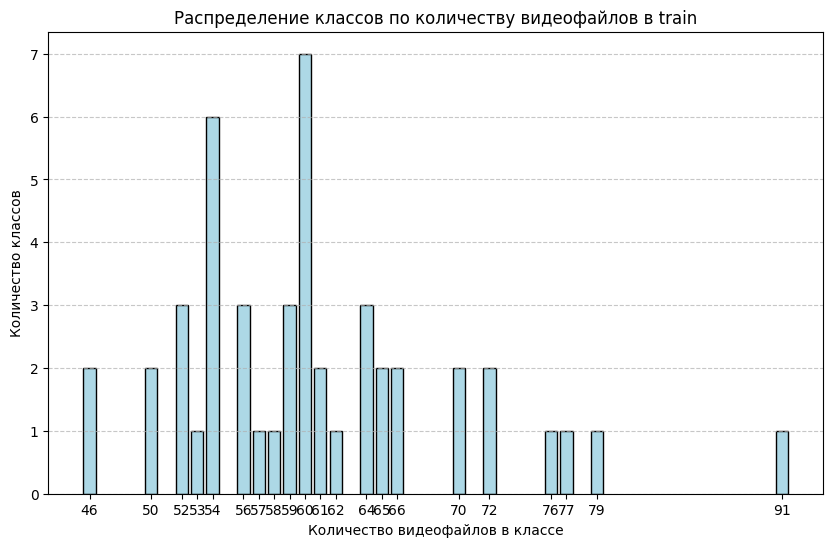

In [114]:
counts = list(folders_by_video_count.keys())
num_folders = [len(folders_by_video_count[count]) for count in counts]
if counts:
    sorted_pairs = sorted(zip(counts, num_folders))
    sorted_counts, sorted_num_folders = zip(*sorted_pairs)
    plt.figure(figsize=(10, 6))
    plt.bar(sorted_counts, sorted_num_folders, color='lightblue', edgecolor='black')
    plt.xlabel('Количество видеофайлов в классе')
    plt.ylabel('Количество классов')
    plt.title(f'Распределение классов по количеству видеофайлов в {split}')
    plt.xticks(sorted_counts)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [115]:
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    smooth_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

I0000 00:00:1761029050.880200  810490 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1
I0000 00:00:1761029050.901015  810490 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1
W0000 00:00:1761029050.909782  914677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761029050.927556  914677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [116]:
def normalize_and_scale(frame):
    if all(x == 0 for x in frame):
        return frame
    coords = np.array(frame).reshape(-1, 3)
    wrist_x, wrist_y, wrist_z = coords[0]
    coords -= [wrist_x, wrist_y, wrist_z]
    scale = np.linalg.norm(coords[0] - coords[9])  # wrist-middle
    if scale > 0:
        coords /= scale
    return coords.flatten().tolist()

In [117]:
def extract_pose_features(frame):
    results_pose = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results_pose.pose_landmarks:
        coords = []
        for lm in results_pose.pose_landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z, lm.visibility])
        coords = np.array(coords, dtype=np.float32)
        pelvis_idx = 23
        base_x, base_y, base_z = coords[4*pelvis_idx:4*pelvis_idx+3]
        coords_reshaped = coords.reshape(-1, 4)
        coords_reshaped[:, :3] -= [base_x, base_y, base_z]
        head_idx = 0
        head_dist = np.linalg.norm(coords_reshaped[head_idx, :3])
        if head_dist > 0:
            coords_reshaped[:, :3] /= head_dist
        return coords_reshaped.flatten().tolist()
    else:
        return [0.0] * (33*4)

def extract_sequence_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        if frame_count % 2 == 0:
            # Hand processing
            results_hands = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            hand_landmarks = []
            for hand_idx in range(2):
                if results_hands.multi_hand_landmarks and hand_idx < len(results_hands.multi_hand_landmarks):
                    for lm in results_hands.multi_hand_landmarks[hand_idx].landmark:
                        hand_landmarks.extend([lm.x, lm.y, lm.z])
                else:
                    hand_landmarks.extend([0.0]*63)
            hand_features = normalize_and_scale(hand_landmarks)
            # Pose processing
            pose_features = extract_pose_features(frame)
            # Объединение
            full_features = hand_features + pose_features
            frames.append(full_features)
        frame_count += 1
        if len(frames) >= SEQUENCE_LENGTH: break
    cap.release()
    if len(frames) < SEQUENCE_LENGTH:
        frames.extend([[0.0]*(21*3*2 + 33*4)]*(SEQUENCE_LENGTH-len(frames)))
    return np.array(frames, dtype=np.float32)

W0000 00:00:1761029051.019737  914682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [124]:
SEQUENCE_LENGTH = 30
NUM_FEATURES_HANDS = 21*3*2
NUM_FEATURES_POSE = 33*4
TOTAL_FEATURES = NUM_FEATURES_HANDS + NUM_FEATURES_POSE # теперь две руки
CACHE_PATH = "dataset_cache.npy"
CACHE_LABELS_PATH = "labels_cache.npy"


def normalize_and_scale(frame):
    if all(x == 0 for x in frame):
        return frame
    coords = np.array(frame).reshape(-1,3)
    wrist_x, wrist_y, wrist_z = coords[0]
    coords -= [wrist_x, wrist_y, wrist_z]
    scale = np.linalg.norm(coords[0] - coords[9])
    if scale > 0:
        coords /= scale
    return coords.flatten()

def extract_pose_features(frame):
    results_pose = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results_pose.pose_landmarks:
        coords = []
        for lm in results_pose.pose_landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z, lm.visibility])
        coords = np.array(coords, dtype=np.float32)
        base_idx = 23
        base_x, base_y, base_z = coords[4*base_idx:4*base_idx+3]
        coords_reshaped = coords.reshape(-1,4)
        coords_reshaped[:,:3] -= [base_x, base_y, base_z]
        head_idx = 0
        head_dist = np.linalg.norm(coords_reshaped[head_idx, :3])
        if head_dist > 0:
            coords_reshaped[:,:3] /= head_dist
        return coords_reshaped.flatten()
    else:
        return np.zeros(33*4, dtype=np.float32)

def extract_sequence_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % 2 == 0:
            # Hand landmarks
            results_hands = hands.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            hand_landmarks = []
            for h_idx in range(2):
                if results_hands.multi_hand_landmarks and h_idx < len(results_hands.multi_hand_landmarks):
                    for lm in results_hands.multi_hand_landmarks[h_idx].landmark:
                        hand_landmarks.extend([lm.x, lm.y, lm.z])
                else:
                    hand_landmarks.extend([0.0]*63)
            hand_features = normalize_and_scale(hand_landmarks)
            # Pose features
            pose_features = extract_pose_features(frame)
            # Объединение признаков
            feature_vector = np.concatenate([hand_features, pose_features])
            frames.append(feature_vector)
        frame_idx += 1
        if len(frames) >= SEQUENCE_LENGTH:
            break
    cap.release()
    # Дополнение нулями
    if len(frames) < SEQUENCE_LENGTH:
        pad = np.zeros(TOTAL_FEATURES, dtype=np.float32)
        frames.extend([pad]*(SEQUENCE_LENGTH - len(frames)))
    return np.array(frames, dtype=np.float32)

# Загрузка данных
def load_data_from_directory(directory, selected_classes, video_extensions, augment=False):
    sequences = []
    labels = []
    for class_idx, class_name in enumerate(selected_classes):
        class_dir = os.path.join(directory, class_name)
        video_files = [f for f in os.listdir(class_dir) if os.path.splitext(f)[1].lower() in video_extensions]
        for video_file in video_files:
            seq = extract_sequence_from_video(os.path.join(class_dir, video_file))
            if augment:
                seq = augment_sequence(seq)
            sequences.append(seq)
            labels.append(class_idx)
    return np.array(sequences), np.array(labels)


def augment_sequence(seq):
    """Data augmentation — шум + небольшое смещение"""
    noise = np.random.normal(0, 0.01, seq.shape)
    shift = np.random.uniform(-0.05, 0.05, (1, seq.shape[1]))
    return seq + noise + shift


In [119]:
selected_classes = class_names[:5]

# Вариант 2: по названию
selected_classes = ['your', 'yes', 'no', 'help', 'right']  # нужные тебе классы

num_classes = len(selected_classes)

In [120]:
sequences = []
labels = []




sequences, labels = [], []
for class_idx, class_name in enumerate(selected_classes):
    class_dir = os.path.join(source_directory, class_name)
    video_files = [f for f in os.listdir(class_dir)
                   if os.path.splitext(f)[1].lower() in video_extensions]
    for video_file in video_files:
        seq = extract_sequence_from_video(os.path.join(class_dir, video_file))
        sequences.append(seq)
        labels.append(class_idx)

X = np.array(sequences)
y = np.array(labels)
np.save(CACHE_PATH, X)
np.save(CACHE_LABELS_PATH, y)


In [127]:
from sklearn.model_selection import train_test_split

X_train, y_train = load_data_from_directory(source_directory, selected_classes, video_extensions, augment=True)
X_val, y_val = load_data_from_directory(val_directory, selected_classes, video_extensions)
X_test, y_test = load_data_from_directory(test_directory, selected_classes, video_extensions)

In [128]:
from tensorflow.keras.utils import to_categorical

label_smoothing_factor = 0.1
y_train_cat = to_categorical(y_train)
y_train_cat = y_train_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_train_cat.shape[1])

y_val_cat = to_categorical(y_val)
y_val_cat = y_val_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_val_cat.shape[1])

y_test_cat = to_categorical(y_test)
y_test_cat = y_test_cat * (1 - label_smoothing_factor) + (label_smoothing_factor / y_test_cat.shape[1])


In [137]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout,
    Bidirectional, LSTM, GRU, MultiHeadAttention, Dense, LayerNormalization,
    GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate
)
from tensorflow.keras.models import Model
def build_model(sequence_len, num_features, num_classes, d_model=256, num_heads=4):
    inputs = Input(shape=(sequence_len, num_features))

    # CNN front-end (Conv -> BN -> Act), расширяем receptive field
    x = Conv1D(128, 5, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = Conv1D(128, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = Conv1D(256, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x); x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    # BiRNN stack (без recurrent_dropout)
    x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(GRU(192, return_sequences=True, dropout=0.2))(x)

    # Проекция в d_model для внимания
    proj = Dense(d_model)(x)

    # Multi-head self-attention + residual + LayerNorm
    attn_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=0.1)(proj, proj)
    x = LayerNormalization(epsilon=1e-5)(proj + attn_out)

    # Position-wise FFN + residual
    ff = Dense(4*d_model, activation='relu')(x)
    ff = Dropout(0.1)(ff)
    ff = Dense(d_model)(ff)
    x = LayerNormalization(epsilon=1e-5)(x + ff)

    # Комбинированный пуллинг
    avg = GlobalAveragePooling1D()(x)
    mx = GlobalMaxPooling1D()(x)
    x = Concatenate()([avg, mx])

    # Head
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dropout(0.2)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Использование
model9 = build_model(SEQUENCE_LENGTH, NUM_FEATURES, num_classes)
model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 30, 126)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 30, 128)   │     80,768 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ conv1d_20[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 30, 128)   │     49,280 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 128)   │        512 │ conv1d_21[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 15, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 15, 128)   │          0 │ max_pooling1d_12… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 15, 256)   │     98,560 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 256)   │      1,024 │ conv1d_22[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 15, 256)   │    196,864 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 256)   │      1,024 │ conv1d_23[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_13    │ (None, 7, 256)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 7, 256)    │          0 │ max_pooling1d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_11    │ (None, 7, 512)    │  1,050,624 │ dropout_19[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 7, 256)    │    656,384 │ bidirectional_11… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 7, 128)    │     32,896 │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 7, 128)    │     32,896 │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 7, 128)    │     32,896 │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 7, 128)    │          0 │ dense_13[0][0],   │
│ (Attention)         │                   │            │ dense_15[0][0], 

 Total params: 6,901,393 (26.33 MB)

 Trainable params: 2,299,781 (8.77 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 4,599,564 (17.55 MB)

In [138]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
callbacks = [
    EarlyStopping(patience=7,restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]


In [139]:
history3 = model9.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val_cat),
    callbacks=callbacks
)

Epoch 1/100
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1735 - loss: 1.9876

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.2202 - loss: 1.8459 - val_accuracy: 0.4250 - val_loss: 1.5691 - learning_rate: 3.0000e-04
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4440 - loss: 1.3126 - val_accuracy: 0.3000 - val_loss: 1.5698 - learning_rate: 3.0000e-04
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6065 - loss: 1.1053 - val_accuracy: 0.2500 - val_loss: 2.0250 - learning_rate: 3.0000e-04
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7352 - loss: 0.9541

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7292 - loss: 0.9741 - val_accuracy: 0.4500 - val_loss: 1.4371 - learning_rate: 3.0000e-04
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.7870 - loss: 0.8075 - val_accuracy: 0.2250 - val_loss: 2.2366 - learning_rate: 3.0000e-04
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9278 - loss: 0.6192 - val_accuracy: 0.3000 - val_loss: 1.7130 - learning_rate: 3.0000e-04
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9806 - loss: 0.5113

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9711 - loss: 0.5234 - val_accuracy: 0.7000 - val_loss: 1.2875 - learning_rate: 3.0000e-04
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9857 - loss: 0.5099

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9819 - loss: 0.5083 - val_accuracy: 0.7250 - val_loss: 0.9609 - learning_rate: 3.0000e-04
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9786 - loss: 0.4834

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9856 - loss: 0.4804 - val_accuracy: 0.8000 - val_loss: 0.9135 - learning_rate: 3.0000e-04
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.4540

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 1.0000 - loss: 0.4576 - val_accuracy: 0.8000 - val_loss: 0.8114 - learning_rate: 3.0000e-04
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9965 - loss: 0.4555

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.9964 - loss: 0.4588 - val_accuracy: 0.9250 - val_loss: 0.5921 - learning_rate: 3.0000e-04
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9935 - loss: 0.4544

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.9928 - loss: 0.4603 - val_accuracy: 0.9250 - val_loss: 0.5137 - learning_rate: 3.0000e-04
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.4473

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.4482 - val_accuracy: 0.9750 - val_loss: 0.4899 - learning_rate: 3.0000e-04
Epoch 14/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9936 - loss: 0.4536

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9964 - loss: 0.4483 - val_accuracy: 1.0000 - val_loss: 0.4403 - learning_rate: 3.0000e-04
Epoch 15/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.4448

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.4450 - val_accuracy: 1.0000 - val_loss: 0.4334 - learning_rate: 3.0000e-04
Epoch 16/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9996 - loss: 0.4382

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9964 - loss: 0.4451 - val_accuracy: 1.0000 - val_loss: 0.4197 - learning_rate: 3.0000e-04
Epoch 17/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.4436

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.4402 - val_accuracy: 1.0000 - val_loss: 0.4106 - learning_rate: 3.0000e-04
Epoch 18/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.4337 - val_accuracy: 1.0000 - val_loss: 0.4249 - learning_rate: 3.0000e-04
Epoch 19/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9964 - loss: 0.4405 - val_accuracy: 0.9000 - val_loss: 0.6065 - learning_rate: 3.0000e-04
Epoch 20/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 1.0000 - loss: 0.4393 - val_accuracy: 0.8750 - val_loss: 0.7045 - learning_rate: 3.0000e-04
Epoch 21/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.4382 - val_accuracy: 1.0000 - val_loss: 0.4195 - learning_rate: 1.5000e-04
Epoch 22/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 0.4294

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 0.4286 - val_accuracy: 1.0000 - val_loss: 0.4042 - learning_rate: 1.5000e-04
Epoch 23/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.4325

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.4330 - val_accuracy: 1.0000 - val_loss: 0.4034 - learning_rate: 1.5000e-04
Epoch 24/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.4363 - val_accuracy: 0.9750 - val_loss: 0.4207 - learning_rate: 1.5000e-04
Epoch 25/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9987 - loss: 0.4328

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9964 - loss: 0.4387 - val_accuracy: 1.0000 - val_loss: 0.4000 - learning_rate: 1.5000e-04
Epoch 26/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 0.4280 - val_accuracy: 0.9750 - val_loss: 0.4205 - learning_rate: 1.5000e-04
Epoch 27/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 0.4324 - val_accuracy: 0.9750 - val_loss: 0.4261 - learning_rate: 1.5000e-04
Epoch 28/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 0.4287 - val_accuracy: 0.9750 - val_loss: 0.4297 - learning_rate: 1.5000e-04
Epoch 29/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.4322 - val_accuracy: 0.9750 - val_loss: 0.4356 - learning_rate: 7.5000e-05
Epoch 30/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 1.0000 - loss: 0.4277 - val_accuracy: 0.9750 - val_loss: 0.4334 - learning_rate: 7.5000e-05
Epoch 31/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9964 - loss: 0.4

In [148]:
from sklearn.metrics import classification_report

y_pred = model9.predict(X_test)
y_true_labels = np.argmax(y_test_cat, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=selected_classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

Classification Report:
              precision    recall  f1-score   support

        your       1.00      1.00      1.00         6
         yes       1.00      1.00      1.00         6
          no       1.00      1.00      1.00         6
        help       1.00      1.00      1.00         7
       right       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



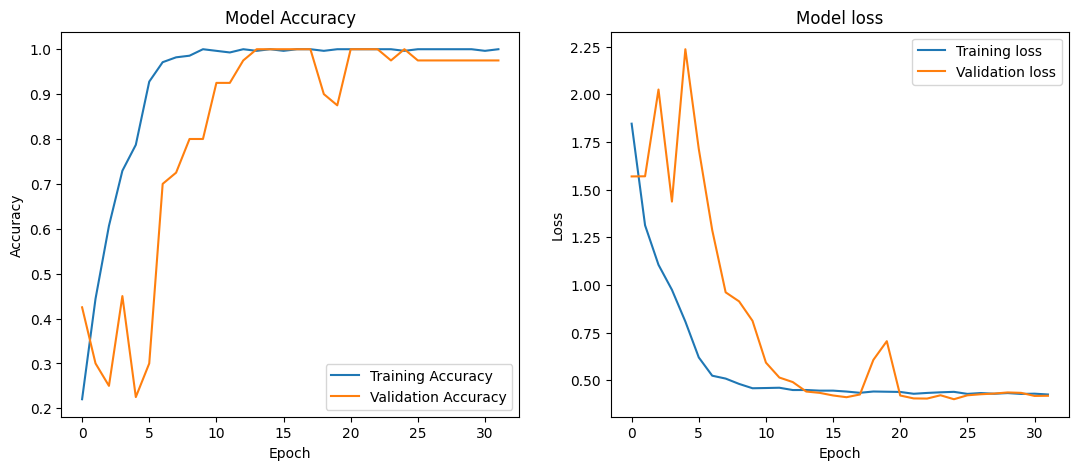

In [146]:
import matplotlib.pyplot as plt

fig, axe = plt.subplots(1, 2, figsize=(13, 5))

axe[0].plot(history3.history['accuracy'], label='Training Accuracy')
axe[0].plot(history3.history['val_accuracy'], label='Validation Accuracy')
axe[0].set_title('Model Accuracy')
axe[0].set_ylabel('Accuracy')
axe[0].set_xlabel('Epoch')
axe[0].legend()

axe[1].plot(history3.history['loss'], label='Training loss')
axe[1].plot(history3.history['val_loss'], label='Validation loss')
axe[1].set_title('Model loss')
axe[1].set_ylabel('Loss')
axe[1].set_xlabel('Epoch')
axe[1].legend()
plt.show()

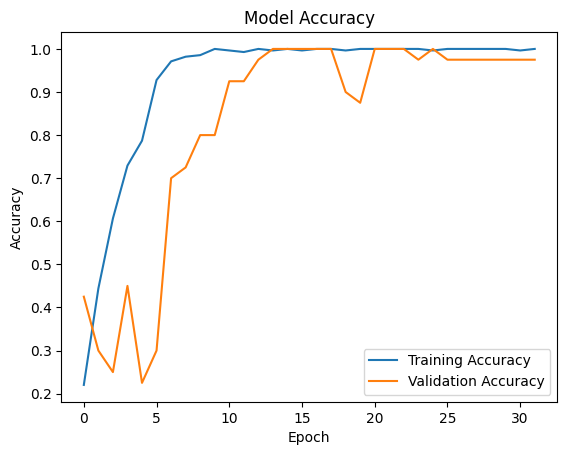

In [147]:
import matplotlib.pyplot as plt

plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [88]:
print("Train classes:", np.unique(np.argmax(y_train_cat, axis=1), return_counts=True))
print("Val classes:", np.unique(np.argmax(y_val_cat, axis=1), return_counts=True))


Train classes: (array([0, 1, 2, 3, 4]), array([52, 54, 52, 60, 59]))
Val classes: (array([0, 1, 2, 3, 4]), array([7, 8, 8, 9, 8]))
